In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm
from shutil import copyfile
import cv2
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [2]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_temporal.npy'
temporal = np.load(file)
temporal = temporal*-1 ### SWITCH SIGN
temporal.shape #timepoint by PC

(30456, 1000)

In [3]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        ### Y and Z ###
        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Interpolate to neural data
            self.fictrac[short] = []
            self.fictrac[short + '_pos'] = []
            self.fictrac[short + '_neg'] = []
            for z in range(49):
                ### Velocity ###
                low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
                #self.fictrac[short].append(low_res_behavior/np.std(low_res_behavior))
                self.fictrac[short].append(low_res_behavior)

                ### Clipped Velocities ###
                self.fictrac[short + '_pos'].append(np.clip(self.fictrac[short][-1], a_min=0, a_max=None))
                self.fictrac[short + '_neg'].append(np.clip(self.fictrac[short][-1], a_min=None, a_max=0)*-1)
                
            ### 10Hz interp ###
            expt_len = 1000*30*60
            sample_in_ms = 100
            x_hz10 = np.arange(0,expt_len,sample_in_ms)
            hz10_res_behavior = self.pull_from_interp_object(interp_object, x_hz10)
            self.fictrac[short + '_10hz'] = hz10_res_behavior
            self.fictrac[short + '_pos_10hz'] = np.clip(hz10_res_behavior, a_min=0, a_max=None)
            self.fictrac[short + '_neg_10hz'] = np.clip(hz10_res_behavior, a_min=None, a_max=0) * -1

        ### Walking ###
        self.fictrac['walking'] = []
        for z in range(49):    
            YZ = np.sqrt(np.power(self.fictrac['Y'][z],2), np.power(self.fictrac['Z'][z],2))        
            self.fictrac['walking'].append(np.zeros(3384))
            self.fictrac['walking'][-1][np.where(YZ>.2)] = 1

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id
    
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    
flies = {}
for i, fly in enumerate(fly_names):
    print(F'*** fly: {fly} ***')
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()

*** fly: fly_087 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 59.99 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 6.17 sec
*** fly: fly_089 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 75.30 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 6.15 sec
*** fly: fly_094 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 42.77 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 6.20 sec
*** fly: fly_097 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 54.45 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 6.24 sec
*** fly: fly_098 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 88.57 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 6.08 sec
*** fly: f

In [4]:
z = 20
sphere_radius = 4.5e-3 # in m
fps=50
behaviors = ['Y', 'Z', 'Y_pos', 'Z_pos', 'Z_neg']
behavior_super = {}
for behavior in behaviors:
    behavior_super[behavior] = []
    for fly in fly_names:
        behavior_super[behavior].extend((flies[fly].fictrac.fictrac[behavior][z]))
    behavior_super[behavior] = np.asarray(behavior_super[behavior])
    behavior_super[behavior + '_std'] = behavior_super[behavior]/np.std(behavior_super[behavior])
    
    if behavior in ['Y', 'Y_pos']:
        ''' starts with units of rad/frame
        * sphere_radius(m); now in m/frame
        * fps; now in m/sec
        * 1000; now in mm/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * sphere_radius * fps * 1000 # mm/sec
        
    elif behavior in ['Z', 'Z_pos', 'Z_neg']:
        ''' starts with units of rad/frame
        * 180 / np.pi; now in deg/frame
        * fps; now in deg/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * 180 / np.pi * fps ## deg/sec

Text(0.5, 0, 'Y_Pos velocity')

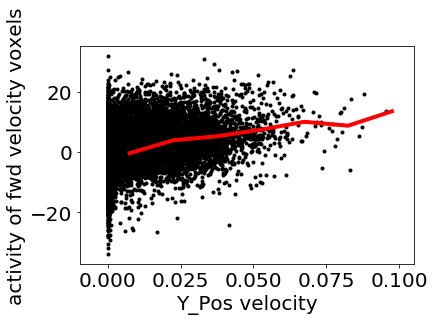

In [5]:
# unique forward...

# make x bins, get mean y in each bin
beh = behavior_super['Y_pos']
pc = 0
neu = temporal[:,pc]
num_bins = 10
xbins = np.linspace(0,.15,num_bins+1)
avgs = []
for i in range(num_bins):
    start = xbins[i]
    end = xbins[i+1]
    a = np.where(np.logical_and(beh>start, beh<=end))
    avgs.append(np.mean(neu[a]))

step = xbins[1] - xbins[0]
mids = [i+step/2 for i in xbins]
plt.scatter(beh,neu,marker='.',color='k')
plt.plot(mids[:-1],avgs,color='r',lw=4)
plt.ylabel('activity of fwd velocity voxels')
plt.xlabel('Y_Pos velocity')

In [6]:
num_bins = 10
xbins = np.linspace(0,5,num_bins+1)
step = xbins[1] - xbins[0]
mids = [i+step/2 for i in xbins]
len(mids)

11

In [7]:
mids

[0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25]

In [9]:
temporal.shape

(30456, 1000)

In [10]:
temporal[:,1] = temporal[:,1]*-1

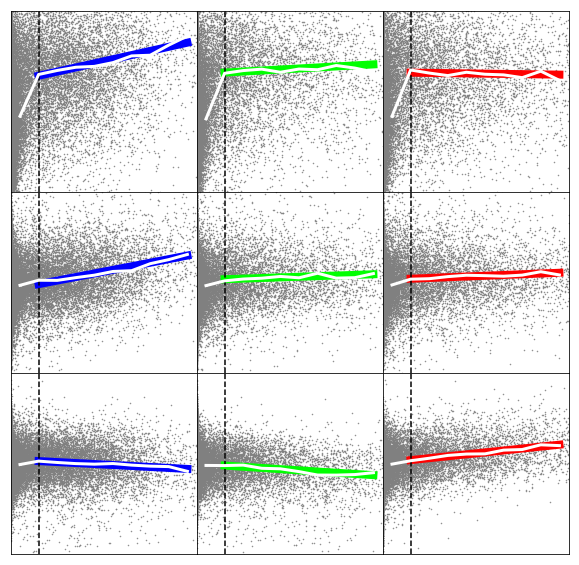

In [16]:
plt.figure(figsize=(10,10))
cnt = 0
rs_low = []
ps_low = []
rs_high = []
ps_high = []

for pc in [0,1,2]:
    for beh in ['Y_pos_std', 'Z_pos_std', 'Z_neg_std']:
        cnt+=1
        plt.subplot(3,3,cnt)
        
        # make x bins, get mean y in each bin
        num_bins = 10
        xbins = np.linspace(0,5,num_bins+1)
        step = xbins[1] - xbins[0]
        mids = [i+step/2 for i in xbins]
        avgs = []
        stds = []
        cnts = []
        for i in range(num_bins):
            start = xbins[i]
            end = xbins[i+1]
            a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
            avgs.append(np.mean(temporal[:,pc][a]))
            stds.append(np.std(temporal[:,pc][a]))
            cnts.append(len(a[0]))
            #plt.boxplot(list(resp[neu][a]),positions=[mids[i]], showfliers=False)

        plt.scatter(behavior_super[beh],temporal[:,pc],marker='.',color='grey',s=1)
        #plt.plot(mids[:-1],avgs,color='r',lw=1,marker='o')
        
        ### Plot line along bins, with error bar ###
        sem = [stds[i]/np.sqrt(cnts[i]) for i in range(len(mids)-1)]
        plt.errorbar(mids[:-1], avgs, yerr=sem, label='both limits (default)',color='w',lw=3)
        
        ### Fit line to data above the threshold ###
        start = mids[1]
        end = 10
        a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
        m, b = np.polyfit(behavior_super[beh][a], temporal[:,pc][a], 1)
        x=[.75,mids[-2]]
        colors = ['blue',(0,1,0),'r']
        plt.plot(x, [i*m + b for i in x],color=colors[(cnt-1)%3],lw=8)
        r, p = scipy.stats.pearsonr(behavior_super[beh][a], temporal[:,pc][a])
        rs_high.append(r)
        ps_high.append(p)
        
        ### Fit line to data BELOW the threshold ###
        start = 0
        end = .75
        a = np.where(np.logical_and(behavior_super[beh]>start, behavior_super[beh]<=end))
        #m, b = np.polyfit(behavior_super[beh][a], resp[neu][a], 1)
#         x=[0,xbins[1]]
#         plt.plot(x, [i*m + b for i in x],color='r',lw=8)
        r, p = scipy.stats.pearsonr(behavior_super[beh][a], temporal[:,pc][a])
        rs_low.append(r)
        ps_low.append(p)
        
        
        plt.axvline(mids[1],color='k',linestyle='--')
        plt.xlim(0,5)
        plt.ylim(-10,10)
        plt.xticks([])
        plt.yticks([])
        #plt.title(F'{r:.2f},{p:.2f}',fontsize=12)
        
plt.subplots_adjust(wspace=0,hspace=0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

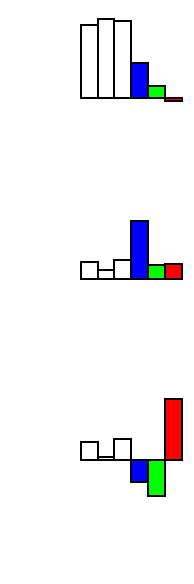

In [18]:
plt.figure(figsize=(2,10))
plt.subplot(3,1,1)
plt.bar([1,2,3,4,5,6],rs_low[:3]+rs_high[:3],
        color=['w','w','w','b',(0,1,0),'r'],width=1.0,edgecolor='k',lw=2)
plt.ylim(-.45,.45)
# plt.xticks([])
plt.yticks([.4])
plt.axis('off')

plt.subplot(3,1,2)
plt.bar([1,2,3,4,5,6],rs_low[3:6]+rs_high[3:6],
        color=['w','w','w','b',(0,1,0),'r'],width=1.0,edgecolor='k',lw=2)
plt.ylim(-.45,.45)
# plt.xticks([])
# plt.yticks([])
plt.axis('off')

plt.subplot(3,1,3)
plt.bar([1,2,3,4,5,6],rs_low[6:9]+rs_high[6:9],
        color=['w','w','w','b',(0,1,0),'r'],width=1.0,edgecolor='k',lw=2)
plt.ylim(-.45,.45)
# plt.xticks([])
# plt.yticks([])
plt.axis('off')

plt.subplots_adjust(wspace=0,hspace=0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [37]:
ps_high

[1.12099771090045e-46,
 0.0001383952208643451,
 0.3317531764877355,
 1.6658411143142148e-133,
 5.51607137428292e-06,
 2.2875839391258127e-07,
 2.0260489686957668e-19,
 7.41783303443096e-32,
 1.1176643473634741e-98]